In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import os

In [42]:
class Node :
    def __init__(self, id, coord_x, coord_y, date_available=0, E=0):
        self.id = id
        self.coord_x = coord_x
        self.coord_y = coord_y
        self.date_available = date_available
        self.E = E
        pass

    def __str__(self):
        return f"Node {self.id}"

class Arc :
    def __init__(self, From_node: Node, To_node: Node, technology: str):
        self.From_node = From_node
        self.To_node = To_node
        self.dist = ((From_node.coord_x-To_node.coord_x)**2 + (From_node.coord_y-To_node.coord_y)**2)**(1/2)
        self.technology = technology
        pass


class Network:
    def __init__(self, storage_sites: dict, capture_sites: dict, rail_matrix):
        self.storage_sites = storage_sites  # Dictionary of storage nodes
        self.capture_sites = capture_sites  # Dictionary of capture nodes
        self.rail_matrix = rail_matrix  # Matrix indicating rail connections
        self.nodes = list(self.storage_sites.values()) + list(self.capture_sites.values())
        self.arcs = []  # List to store Arc objects
        self.output_folder = "data/medium_instance/"
        os.makedirs(self.output_folder, exist_ok=True)

    def generate_arcs(self):
        
        # Create arcs with technology "A" and "B"
        for i in range(len(self.nodes)):
            for j in range(len(self.nodes)):
                if i != j:
                    self.arcs.append(Arc(self.nodes[i], self.nodes[j], "truck"))
                    self.arcs.append(Arc(self.nodes[i], self.nodes[j], "pipeline"))
                    
                    # Check rail matrix for technology "C"
                    if self.rail_matrix[i][j] == 1:
                        self.arcs.append(Arc(self.nodes[i], self.nodes[j], "train"))


    def visualize(self):
        plt.figure(figsize=(8, 6))
        nodes = list(self.storage_sites.values()) + list(self.capture_sites.values())
        
        # Plot nodes
        for node in nodes:
            plt.scatter(node.coord_x, node.coord_y, color='blue', s=100)
            plt.text(node.coord_x, node.coord_y, f"{node.id}", fontsize=12, ha='right')
        
        # Define colors for different technologies
        tech_colors = {"truck": "red", "pipeline": "green", "train": "blue"}
        
        # Plot arcs
        for arc in self.arcs:
            plt.plot([arc.From_node.coord_x, arc.To_node.coord_x], 
                     [arc.From_node.coord_y, arc.To_node.coord_y],
                     color=tech_colors.get(arc.technology, "black"), alpha=0.5, label=arc.technology)
        
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.title("Network Visualization")
        plt.show()

    def export_to_csv(self):
        # Export storage sites
        with open(os.path.join(self.output_folder, 'storage_sites.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["id", "coord_x", "coord_y", "date_available", "E"])
            for node in self.storage_sites.values():
                writer.writerow([node.id, node.coord_x, node.coord_y, node.date_available, node.E])
        
        # Export capture sites
        with open(os.path.join(self.output_folder, 'capture_sites.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["id", "coord_x", "coord_y", "date_available", "E"])
            for node in self.capture_sites.values():
                writer.writerow([node.id, node.coord_x, node.coord_y, node.date_available, node.E])
        
        # Export arcs
        with open(os.path.join(self.output_folder, 'arcs.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["From", "To", "Technology", "Distance"])
            for arc in self.arcs:
                writer.writerow([arc.From_node.id, arc.To_node.id, arc.technology, arc.dist])
        
        # Export time steps
        with open(os.path.join(self.output_folder, 'time_steps.csv'), 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["Time Step"])
            for t in range(26):  # Time steps from 0 to 25
                writer.writerow([t])



In [38]:
def parse_instance_file(file_path):
    """Parses the instance_medium_P4.txt file to extract graph components."""
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Extract time horizon
    T = int(lines[1].split('=')[1].strip())

    # Extract number of nodes, storage sites, and transport hubs
    N = int(lines[3].split('=')[1].strip())
    n_storage = int(lines[6].split('=')[1].strip())

    # Extract storage site details
    storage_sites = {}
    storage_start = 13  # Numerical data starts at line 14 (index 13)
    for i in range(n_storage):
        parts = list(map(float, lines[storage_start + i].split(',')))
        storage_sites[int(parts[0])] = Node(id=int(parts[0]), coord_x=parts[1], coord_y=parts[2], date_available=int(parts[3]))

    # Extract capture site details
    n_capture = int(lines[17].split('=')[1].strip())  # Line containing the number of capture sites
    capture_sites = {}
    capture_start = 24  # Numerical data starts at line 24 (index 23)
    for i in range(n_capture):
        parts = list(map(float, lines[capture_start + i].split(',')))
        capture_sites[int(parts[0])] = Node(id=int(parts[0]), coord_x=parts[1], coord_y=parts[2], E=parts[3])

    # Extract transport hubs and add them to capture_sites with E=0
    n_hubs = int(lines[35].split('=')[1].strip())  # Line containing n_hubs
    hub_start = 41  # Numerical data starts at line 39 (index 38)
    for i in range(n_hubs):
        parts = list(map(float, lines[hub_start + i].split(',')))
        capture_sites[int(parts[0])] = Node(id=int(parts[0]), coord_x=parts[1], coord_y=parts[2], E=0)  # Emission set to 0

    # Extract rail connections
    rail_start = 45  # Rail matrix starts at line 41 (index 40)
    rail_matrix = []
    for i in range(N):
        rail_matrix.append(list(map(int, lines[rail_start + i].split(','))))

    return T, storage_sites, capture_sites, rail_matrix


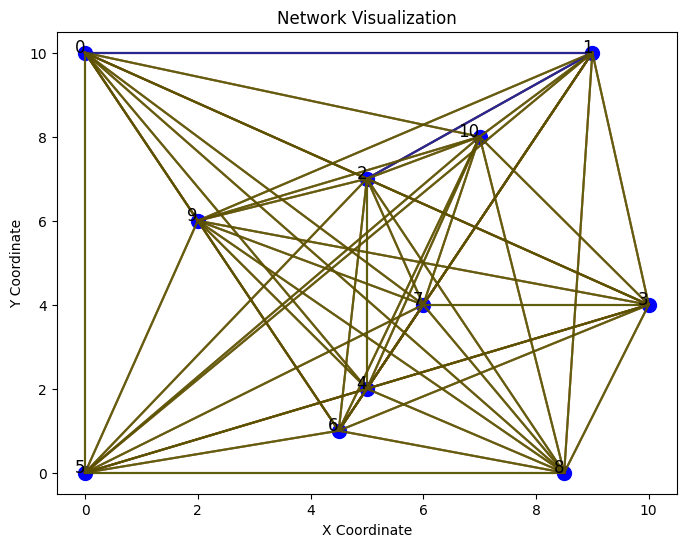

In [39]:
T, S, C, R = parse_instance_file("data/instance_medium_P4.txt")
net = Network(S,C,R)
net.generate_arcs()
net.visualize()

In [41]:
net.export_to_csv()